### Scaling scenario

In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import torch
import numpy as np
import random
import os

torch.cuda.set_device(0) 

def seed_all(seed=4):
    """Set all random seeds for reproducibility."""
    # Python random module
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch (CPU and CUDA)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)  # For multi-GPU
    
    # PyTorch deterministic algorithms (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set PYTHONHASHSEED for Python hashing (optional)
    os.environ["PYTHONHASHSEED"] = str(seed)

# Usage
seed_all(0)  # Sets all seeds to 42

In [3]:
from time import time
from itertools import product

from scipy.optimize import linear_sum_assignment
import numpy as np
import torch
import pandas as pd
from tqdm import tqdm

from torch_linear_assignment import batch_linear_assignment

is_cuda = torch.cuda.is_available()
assert is_cuda, 'Requires CUDA!'

def nr_nc_ratio(nr, nc, factor=1):
    bs = 1
    torch.cuda.synchronize()
    costs = torch.arange(bs * nr * nc)[torch.randperm(bs * nr * nc)].reshape(bs, nr, nc) * factor
    if is_cuda:
        costs = costs.to('cuda')
    t = time()
    result_own = batch_linear_assignment(costs)
    t = time() - t
    result_ref = linear_sum_assignment(costs[0].cpu().numpy())
    del costs
    torch.cuda.empty_cache()
    return (result_own.cpu().numpy()[0, result_ref[0]] == result_ref[1]).sum() / len(result_ref[1]), t


In [4]:
results = []
REPS = 10
factors = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10,
                                                                        1e4, 1e8]
nrs = [4, 16, 64, 128]
ncs = [4, 16, 64, 128]

In [5]:
for nr, nc, factor in tqdm(product(nrs, ncs, factors)):
    times = [] 
    right_rate = []
    for i in range(REPS):
        rate, t = nr_nc_ratio(nr, nc, factor)
        times.append(t)
        right_rate.append(rate)
    times = np.array(times)
    right_rate = np.array(right_rate)
    results.append(
        (nr, nc, factor, right_rate.mean(), right_rate.std(), times.mean(), times.std())
    )
    

208it [00:03, 53.99it/s] 


In [6]:
columns = ['nr', 'nc', 'factor', 'acc_mean', 'acc_std', 'time_mean', 'time_std']
resdf = pd.DataFrame(data=results, columns=columns)

In [7]:
resdf.describe()

,nr,nc,factor,acc_mean,acc_std,time_mean,time_std
count,208.000000,208.000000,2.080000e+02,208.000000,208.000000,208.000000,2.080000e+02
mean,53.000000,53.000000,7.693077e+06,0.998002,0.005995,0.000080,4.196077e-05
std,48.892666,48.892666,2.671100e+07,0.009371,0.028113,0.000191,5.723054e-04
min,4.000000,4.000000,1.000000e-10,0.925000,0.000000,0.000058,5.955694e-07
25%,13.000000,13.000000,1.000000e-07,1.000000,0.000000,0.000059,9.277665e-07
50%,40.000000,40.000000,1.000000e-04,1.000000,0.000000,0.000065,1.243553e-06
75%,80.000000,80.000000,1.000000e-01,1.000000,0.000000,0.000072,2.420565e-06
max,128.000000,128.000000,1.000000e+08,1.000000,0.225000,0.002819,8.255953e-03


In [8]:
ref_main = pd.read_csv('/root/torch-linear-assignment/experiments/res_scale_main.csv')
agg_by_nc_nr_ref = ref_main.groupby(['nc', 'nr']).agg({'time_mean': 'mean'}).reset_index()
ratios_ref = (agg_by_nc_nr_ref.nc / agg_by_nc_nr_ref.nr).values
sorted_index_ref = ratios_ref.argsort()

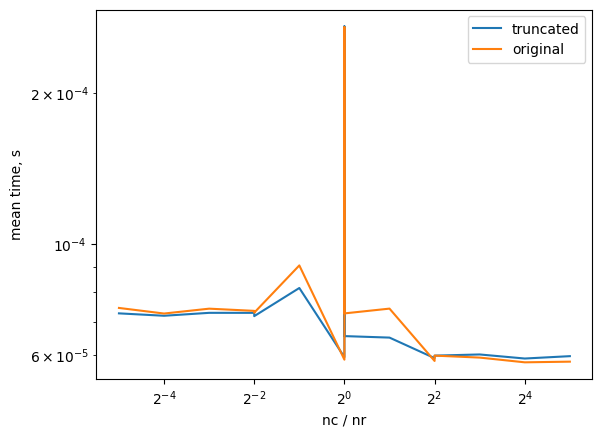

In [9]:
import matplotlib.pyplot as plt 

agg_by_nc_nr = resdf.groupby(['nc', 'nr']).agg({'time_mean': 'mean'}).reset_index()
ratios = (agg_by_nc_nr.nc / agg_by_nc_nr.nr).values
sorted_index = ratios.argsort()
plt.plot(ratios[sorted_index], agg_by_nc_nr.time_mean.values[sorted_index], label='truncated')
plt.plot(ratios_ref[sorted_index], agg_by_nc_nr_ref.time_mean.values[sorted_index], label='original')
plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('nc / nr')
plt.ylabel('mean time, s')
plt.legend();


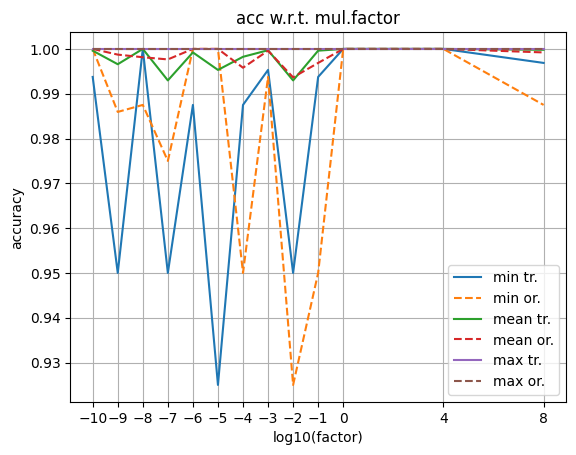

In [10]:
# sorted_index = resdf.factor.argsort()

agg = 'mean'
agg_by_factor = resdf.groupby('factor', sort=True).agg({'acc_mean': ['min', agg, 'max']}).reset_index()

agg_by_factor_ref = ref_main.groupby('factor', sort=True).agg({'acc_mean': ['min', agg, 'max']}).reset_index()


for t in ['min', agg, 'max']:

    plt.plot(
        np.log10(agg_by_factor.factor), agg_by_factor[('acc_mean', t)], label=t + ' tr.', ls='-'
    )
    plt.plot(
        np.log10(agg_by_factor_ref.factor), agg_by_factor_ref[('acc_mean', t)], label=t + ' or.', ls='--'
    )

# plt.xscale('log', base=10)
plt.xticks(np.log10(factors));
plt.grid();
plt.legend();
plt.title('acc w.r.t. mul.factor');
plt.xlabel('log10(factor)');
plt.ylabel('accuracy');

### shifting scanario

In [11]:
def nr_nc_ratio_shift(nr, nc, shift=0):
    bs = 1
    costs = torch.arange(bs * nr * nc, device='cpu')[torch.randperm(bs * nr * nc)].reshape(bs, nr, nc).float().cuda()
    costs = costs / (bs * nr * nc - 1)
    costs = costs + (shift)
    # if is_cuda:
    #     costs = costs.to('cuda')
    t = time()
    result_own = batch_linear_assignment(costs)
    t = time() - t
    result_ref = linear_sum_assignment(costs[0].cpu().numpy())
    del costs
    torch.cuda.empty_cache()
    return (result_own.cpu().numpy()[0, result_ref[0]] == result_ref[1]).sum() / len(result_ref[1]), t

**Interesting fact! shift >= 1e8 causes bad memory allocation!**

In [ ]:
results_shift = []
REPS = 10
shifts = [1, 1e2, 1e4, 1e6,
        #    1e8,
        #    1e10
           ]
nrs = [4, 16, 64, 128]
ncs = [4, 16, 64, 128]

for nr, nc, shift in tqdm(product(nrs, ncs, shifts)):
    torch.cuda.synchronize()
    times = [] 
    right_rate = []
    for i in range(REPS):
        rate, t = nr_nc_ratio_shift(nr, nc, shift)
        times.append(t)
        right_rate.append(rate)
    times = np.array(times)
    right_rate = np.array(right_rate)
    results_shift.append(
        (nr, nc, shift, right_rate.mean(), right_rate.std(), times.mean(), times.std())
    )
    

In [13]:
columns = ['nr', 'nc', 'shift', 'acc_mean', 'acc_std', 'time_mean', 'time_std']
resdf_shift = pd.DataFrame(data=results_shift, columns=columns)

ref_shift = pd.read_csv('/root/torch-linear-assignment/experiments/res_shift_main.csv')

In [14]:
ref_shift = pd.read_csv('/root/torch-linear-assignment/experiments/res_shift_main.csv')

/tmp/ipykernel_25644/2469109411.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


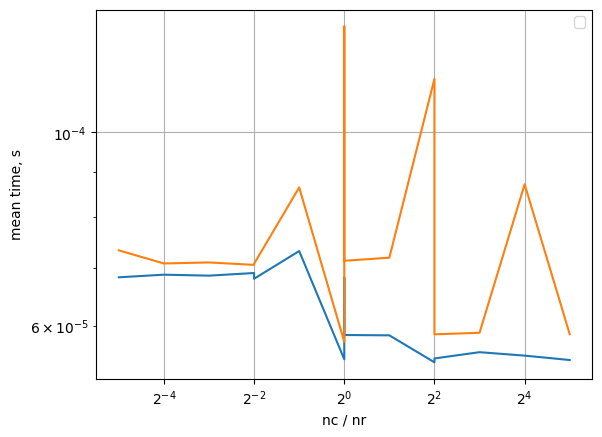

In [ ]:
agg_by_nc_nr = resdf_shift.groupby(['nc', 'nr']).agg({'time_mean': 'mean'}).reset_index()
ratios = (agg_by_nc_nr.nc / agg_by_nc_nr.nr).values
sorted_index = ratios.argsort()
plt.plot(ratios[sorted_index], agg_by_nc_nr.time_mean.values[sorted_index], label='tr.')

agg_by_nc_nr_shift = ref_shift.groupby(['nc', 'nr']).agg({'time_mean': 'mean'}).reset_index()
ratios_shift = (agg_by_nc_nr_shift.nc / agg_by_nc_nr_shift.nr).values
sorted_index_shift = ratios_shift.argsort()
plt.plot(ratios_shift[sorted_index_shift], agg_by_nc_nr_shift.time_mean.values[sorted_index_shift])

plt.xscale('log', base=2)
plt.yscale('log')
plt.xlabel('nc / nr')
plt.ylabel('mean time, s')
plt.legend()
plt.title('mean time w.r.t. add.shift');
plt.grid();


In [18]:
resdf_shift.to_csv('/root/torch-linear-assignment/experiments/res_shift_crop.csv')

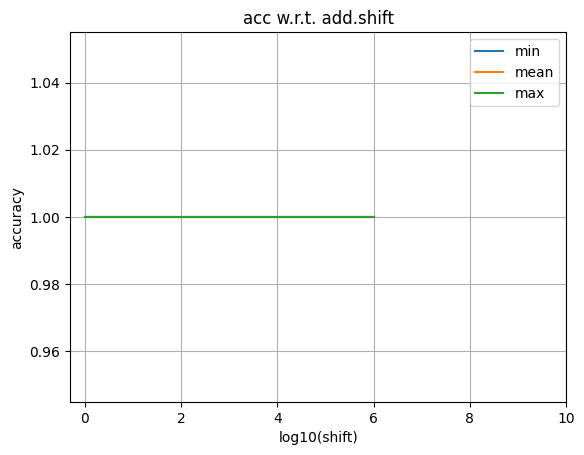

In [19]:
agg = 'mean'
agg_by_shift = resdf_shift.groupby('shift', sort=True).agg({'acc_mean': ['min', agg, 'max']}).reset_index()

for t in ['min', agg, 'max']:
    plt.plot(
        np.log10(agg_by_shift['shift']), agg_by_shift[('acc_mean', t)], label=t
    )

# plt.xscale('log', base=10)
plt.xticks(np.log10(shifts));
plt.grid();
plt.legend();
plt.title('acc w.r.t. add.shift');
plt.xlabel('log10(shift)');
plt.ylabel('accuracy');

In [ ]:
resdf_shift.to_csv('/root/torch-linear-assignment/experiments/res_shift_main.csv')

In [ ]:
resdf_shift_crop = pd.read_csv('/root/torch-linear-assignment/experiments/res_shift_crop.csv')

In [ ]:
resdf_shift - resdf_shift_crop